In [1]:
using Revise
using VCFTools
using MendelImpute
using VariantCallFormat
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
using DelimitedFiles
using JLSO
using StatsBase
using CSV, DataFrames
using Statistics
using LaTeXStrings
# using ProfileView

BLAS.set_num_threads(1)
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")

# Filter

For 1000 genomes panel, we will take 2 samples from each of the 26 populations (total $n = 52$) to form the imputation targets. The remaining samples will serve as reference panels. 

In [2]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function filter_and_mask(chr::Int)
    data = "/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/1000genomes_raw/ALL.chr$chr.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"

    # maps sample ID to 26 populations
    refID_to_population = thousand_genome_samples_to_population()

    # need full sample ID list
    sampleIDs = sampleID(data)

    # filter chromosome data for unique snps
    full_record_index = .!find_duplicate_marker(data)
    VCFTools.filter(data, full_record_index, 1:nsamples(data), 
        des = "chr$chr.uniqueSNPs.vcf.gz")

    # import VCF data with only unique SNPs
    _, vcf_sampleID, _, vcf_record_pos, _, _, _ = convert_gt(UInt8,
        "chr$chr.uniqueSNPs.vcf.gz", save_snp_info=true, msg="importing")
    total_snps = length(vcf_record_pos)
    samples = length(vcf_sampleID)

    # imputation target ids (2 sample from each population) and reference sample ids
    sample_idx = Int[]
    for pop in unique(values(refID_to_population))
        idx = findall(isequal(pop), [refID_to_population[id] for id in sampleIDs])
        push!(sample_idx, idx[1])
        push!(sample_idx, idx[2])
    end
    ref_idx = Int[]
    for i in 1:length(sampleIDs)
        i in sample_idx || push!(ref_idx, i)
    end

    # generate target panel with all snps
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
        sample_idx, des = "target.chr$chr.full.vcf.gz", allow_multiallelic=false)

    # also generate reference panel
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
        ref_idx, des = "ref.chr$chr.vcf.gz", allow_multiallelic=false)

    # generate target file with whose snps are on Omni5.4 chip
    bed = CSV.read("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/omni_chips/InfiniumOmni5-4v1-2_A1.bed",
        skipto = 2, header=false, delim='\t', DataFrame)
    typed_snppos = bed[findall(x -> x == "chr$chr", bed[!, 1]), 3]
    match_idx = indexin(vcf_record_pos, typed_snppos)
    record_idx = falses(total_snps)
    record_idx[findall(!isnothing, match_idx)] .= true
    VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", record_idx, sample_idx,
        des = "target.chr$chr.typedOnly.vcf.gz", allow_multiallelic=false)
    
    # unphase and mask 0.1% entries in target file
    p = nrecords("target.chr$chr.typedOnly.vcf.gz")
    n = nsamples("target.chr$chr.typedOnly.vcf.gz")
    masks = falses(p, n)
    missingprop = 0.001
    for j in 1:n, i in 1:p
        rand() < missingprop && (masks[i, j] = true)
    end
    mask_gt("target.chr$chr.typedOnly.vcf.gz", masks,
        des="target.chr$chr.typedOnly.masked.vcf.gz", unphase=true)

    # Compress reference file to VCF
    d = 1000
    @time compress_haplotypes("ref.chr$chr.vcf.gz", "target.chr$chr.typedOnly.masked.vcf.gz",
        "ref.chr$chr.jlso", d)
end
@time filter_and_mask(20)

finding duplicate markers...100%|███████████████████████| Time: 0:20:42
filtering vcf file...100%|██████████████████████████████| Time: 0:22:14
importing100%|██████████████████████████████████████████| Time: 0:15:47
filtering vcf file...100%|██████████████████████████████| Time: 0:19:11
filtering vcf file...100%|██████████████████████████████| Time: 0:36:12
filtering vcf file...100%|██████████████████████████████| Time: 0:19:24
Importing genotype file...100%|█████████████████████████| Time: 0:00:05
importing reference data...100%|████████████████████████| Time: 0:16:03


1490.751670 seconds (8.90 G allocations: 823.490 GiB, 32.76% gc time, 0.01% compilation time)
9679.915217 seconds (99.62 G allocations: 8.966 TiB, 19.46% gc time, 0.10% compilation time)


In [3]:
@time filter_and_mask(10)

finding duplicate markers...100%|███████████████████████| Time: 0:45:41
filtering vcf file...100%|██████████████████████████████| Time: 0:52:16
importing100%|██████████████████████████████████████████| Time: 0:43:49
filtering vcf file...100%|██████████████████████████████| Time: 0:43:04
filtering vcf file...100%|██████████████████████████████| Time: 1:17:46
filtering vcf file...100%|██████████████████████████████| Time: 0:42:43
Importing genotype file...100%|█████████████████████████| Time: 0:00:11
importing reference data...100%|████████████████████████| Time: 0:48:26


6298.848814 seconds (19.56 G allocations: 1.978 TiB, 61.28% gc time)
24942.065390 seconds (219.22 G allocations: 19.950 TiB, 30.09% gc time)


# Impute

In [2]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")

chr = 10
tgtfile = "target.chr$chr.typedOnly.masked.vcf.gz"
reffile = "ref.chr$chr.jlso"
outfile = "mendelimpute.chr$chr.imputed.vcf.gz"
phase(tgtfile, reffile, outfile);

Number of threads = 8
Importing reference haplotype data...


Importing genotype file...100%|█████████████████████████| Time: 0:00:12
Computing optimal haplotypes...100%|████████████████████| Time: 0:00:07
Writing to file...100%|█████████████████████████████████| Time: 0:00:07


Total windows = 2127, averaging ~ 555 unique haplotypes per window.

Timings: 
    Data import                     = 64.0491 seconds
        import target data             = 14.7868 seconds
        import compressed haplotypes   = 49.2623 seconds
    Computing haplotype pair        = 8.40126 seconds
        BLAS3 mul! to get M and N      = 0.325869 seconds per thread
        haplopair search               = 1.68813 seconds per thread
        initializing missing           = 0.0137521 seconds per thread
        allocating and viewing         = 0.127749 seconds per thread
        index conversion               = 0.000628063 seconds per thread
    Phasing by win-win intersection = 2.36312 seconds
        Window-by-window intersection  = 0.0416319 seconds per thread
        Breakpoint search              = 0.796217 seconds per thread
        Recording result               = 0.019305 seconds per thread
    Imputation                     = 10.7201 seconds
        Imputing missing            

In [31]:
# check raw error rate
using VCFTools
Xmendel = convert_gt(Float64, outfile)
Xbeagle = convert_gt(Float64, "beagle.chr20.imputed.vcf.gz")
Xtrue = convert_gt(Float64, "target.chr$chr.full.vcf.gz")
m, n = size(Xtrue)
println("Mendel error = $(sum(Xtrue .!= Xmendel) / m / n)")
println("Beagle error = $(sum(Xtrue .!= Xbeagle) / m / n)");

Mendel error = 0.0033816817191977618
Beagle error = 0.0020999797135162657


In [ ]:
# raw error rate
using VCFTools
chr = 10
Xmendel = convert_gt(Float64, outfile)
Xbeagle = convert_gt(Float64, "beagle.imputed.chr$chr.vcf.gz")
Xtrue = convert_gt(Float64, "target.chr$chr.full.vcf.gz")
m, n = size(Xtrue)
println("Mendel error = $(sum(Xtrue .!= Xmendel) / m / n)")
println("Beagle error = $(sum(Xtrue .!= Xbeagle) / m / n)");

# Compute $r^2$

In [28]:
"""
Computes r2 for SNPs that have minor allele counts between a certain range specified in `maf_bins`.
"""
function compute_r2_by_maf(
    minor_allele_count::AbstractVector,
    minor_allele_freq::AbstractVector,
    Xtrue::AbstractMatrix,
    Xtest::AbstractMatrix;
    verbose::Bool = false
    )
#     maf_bins = [(1, 1), (2, 2), (2.999999999999, 3.000000000001), (4, 4), (14, 18), (70, 90), (300, 500), (1500, 2500)] # min/max
    maf_bins = [(1, 1), (2, 2), (4, 4), (14, 18), (70, 90), (300, 500), (1500, 2500)] # min/max
    r2 = zeros(length(maf_bins))
    xtrue = Vector{Vector{Float64}}()
    ximpute = Vector{Vector{Float64}}()
    for (i, maf) in enumerate(maf_bins)
        idx = findall(x -> maf[1] ≤ x ≤ maf[2], minor_allele_count)
        for j in idx
            push!(xtrue, @view(Xtrue[:, j]))
            push!(ximpute, @view(Xtest[:, j]))
        end
        r2[i] = abs2(cor(vcat(xtrue...), vcat(ximpute...)))
        verbose && println("mafbin = $maf has $(length(idx)) matches and r2 = $(r2[i])")
    end
    return r2
end

compute_r2_by_maf

## Chr 20

mafbin = (1, 1) has 760830 matches and r2 = 0.522969041200523
mafbin = (2, 2) has 195194 matches and r2 = 0.5537396476881119
mafbin = (4, 4) has 61008 matches and r2 = 0.5955419077367167
mafbin = (14, 18) has 46302 matches and r2 = 0.6735544729957881
mafbin = (70, 90) has 23417 matches and r2 = 0.7909266840585543
mafbin = (300, 500) has 27798 matches and r2 = 0.9240226795397444
mafbin = (1500, 2500) has 53255 matches and r2 = 0.9689365890338145


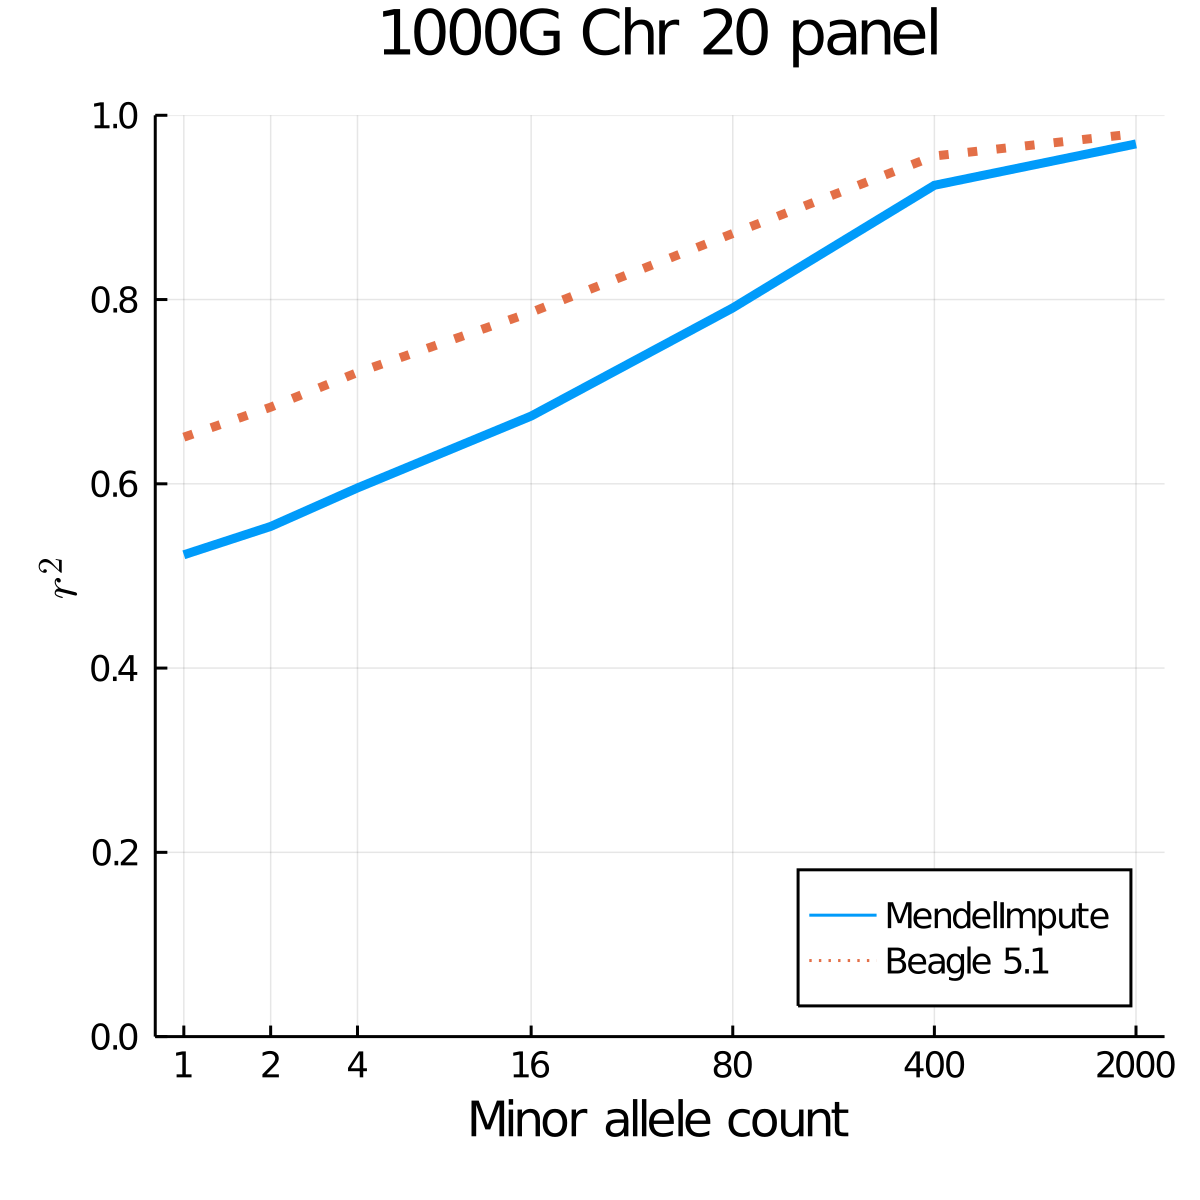

In [38]:
# first compute maf
# chr = 20
# ref = "ref.chr$chr.vcf.gz"
# records, samples, lines, missings_by_sample, missings_by_record,
#     maf_by_record, minorallele_by_record, hwe_by_record = gtstats(ref)
# writedlm("chr$chr.maf", maf_by_record)

chr = 20
mafs = vec(readdlm("chr$chr.maf"))
minor_allele_count = mafs .* 2nsamples("ref.chr$chr.vcf.gz")
maf_bins = [1, 2, 4, 16, 80, 400, 2000]

# import data
Xmendel = convert_gt(Float64, outfile)
Xbeagle = convert_ds(Float64, "beagle.imputed.chr$chr.vcf.gz")
Xtrue = convert_gt(Float64, "target.chr$chr.full.vcf.gz")
m, n = size(Xtrue)

r2_mendel = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Xmendel, verbose=true)
# r2_impute5 = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Ximp5)
r2_beagle5 = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Xbeagle)
# r2_mimimac4 = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Xmmac4)
sleep(1)

chr20_plt = plot(maf_bins, r2_mendel, label="MendelImpute", legend=:bottomright, lw = 3,
    xlabel="Minor allele count", ylabel=latexstring("\$r^2\$"), xaxis=:log, linestyle=:solid,
    xtick=(maf_bins, string.(maf_bins)), dpi=300, size=(400, 400), ylim=(0, 1),
    title="1000G Chr 20 panel")
# plot!(chr20_plt, maf_bins, r2_impute5, label="Impute 5", lw = 3, linestyle=:dash)
plot!(chr20_plt, maf_bins, r2_beagle5, label="Beagle 5.1", lw = 3, linestyle=:dot)
# plot!(chr20_plt, maf_bins, r2_mimimac4, label="Minimac 4", lw = 3, linestyle=:dashdot)

savefig(chr20_plt, "chr$chr.r2.png");
display("image/png", read("chr$chr.r2.png"))

## Chr 10

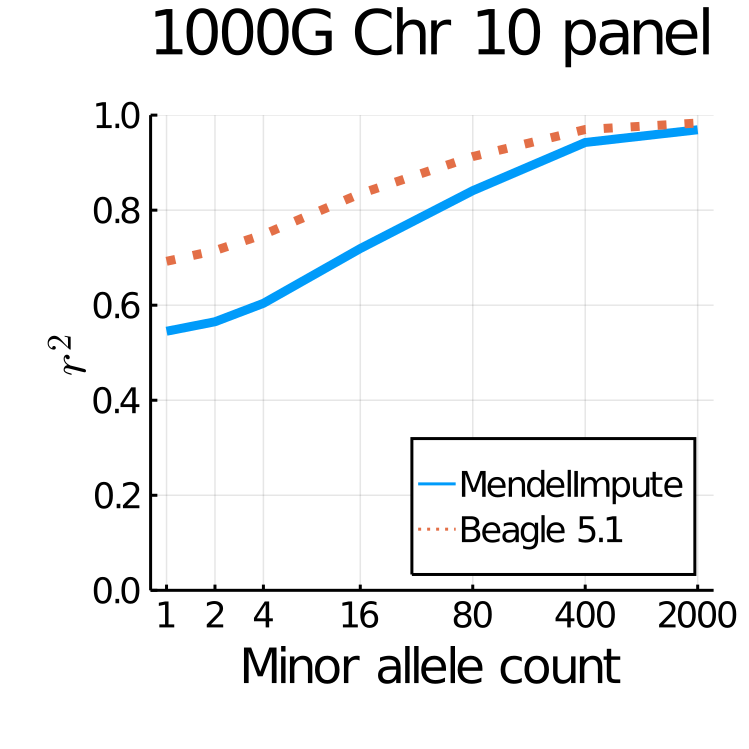

In [21]:
# first compute maf
# chr = 10
# ref = "ref.chr$chr.vcf.gz"
# records, samples, lines, missings_by_sample, missings_by_record,
#     maf_by_record, minorallele_by_record, hwe_by_record = gtstats(ref)
# writedlm("chr$chr.maf", maf_by_record)

mafs = vec(readdlm("chr$chr.maf"))
minor_allele_count = mafs .* 2nsamples("ref.chr$chr.vcf.gz")
maf_bins = [1, 2, 4, 16, 80, 400, 2000]

# import data
# Xmendel = convert_gt(Float64, outfile)
# Xbeagle = convert_ds(Float64, "beagle.imputed.chr$chr.vcf.gz")
# Xtrue = convert_gt(Float64, "target.chr$chr.full.vcf.gz")
m, n = size(Xtrue)

# r2_mendel = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Xmendel, verbose=true)
# r2_impute5 = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Ximp5)
# r2_beagle5 = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Xbeagle)
# r2_mimimac4 = compute_r2_by_maf(minor_allele_count, mafs, Xtrue, Xmmac4)
sleep(1)

chr10_plt = plot(maf_bins, r2_mendel, label="MendelImpute", legend=:bottomright, lw = 3,
    xlabel="Minor allele count", ylabel=latexstring("\$r^2\$"), xaxis=:log, linestyle=:solid,
    xtick=(maf_bins, string.(maf_bins)), dpi=300, size=(250, 250), ylim=(0, 1),
    title="1000G Chr 10 panel")
# plot!(chr10_plt, maf_bins, r2_impute5, label="Impute 5", lw = 3, linestyle=:dash)
plot!(chr10_plt, maf_bins, r2_beagle5, label="Beagle 5.1", lw = 3, linestyle=:dot)
# plot!(chr10_plt, maf_bins, r2_mimimac4, label="Minimac 4", lw = 3, linestyle=:dashdot)

savefig(chr10_plt, "chr$chr.r2.png");
display("image/png", read("chr$chr.r2.png"))